In [35]:
import logging
import hydra
import os
from tqdm import tqdm
import wandb
from pathlib import Path
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from torchmetrics.classification import BinaryJaccardIndex, MulticlassJaccardIndex
import pandas as pd
# from evaluate import evaluate, evaluate_withAddedLAyer
import matplotlib.pyplot as plt
from matplotlib import gridspec
from torchmetrics.functional.classification import binary_f1_score
import unet_model
# import unet_RA_model
from matplotlib.colors import ListedColormap
from PIL import Image
import torchvision.transforms as T
import wandb
from utils import load_image, load_test_image
import cv2
import numpy as np
import random
from skimage.feature import match_template
from scipy import stats

# import geopandas as gpd

In [36]:
# !pip install scikit-image

In [37]:
def crop_reference_image(image, xr, yr):
    x_i = random.randint(300, 700)
    y_i = random.randint(300, 700)
    xstart = max(0, xr+x_i-1000)
    xend= min(image.shape[0],xr+x_i)
    ystart = max(0, yr+y_i-1000)
    yend=min(image.shape[1], yr+y_i)
    
    print(xstart,xend,ystart,yend)
    image_cropped = image[xstart:xend,ystart:yend]
    
    return image_cropped, xstart, xend, ystart, yend

In [38]:
def average_coords(x_forest,x_grass, x_crop,x_water,y_forest,y_grass, y_crop,y_water, x0,y0, threshold=1):
    x=[x_forest,x_grass, x_crop,x_water]
    y=[y_forest,y_grass, y_crop,y_water]
    x_for_averaging = np.array([])
    y_for_averaging = np.array([])
    contributed_classes=np.array([])
    for count, x_each in enumerate(x):
        print(x[count],x0, y[count],y0)
        if (abs(x[count]-x0)<threshold) & (abs(y[count]-y0)<threshold):
            x_for_averaging = np.append(x_for_averaging, x[count])
            y_for_averaging = np.append(y_for_averaging, y[count])
            contributed_classes = np.append(contributed_classes, "yes")
        else:
            contributed_classes = np.append(contributed_classes, "no")
            
    
    x_maxv, ymaxv = x_for_averaging.sum()/len(x_for_averaging) , y_for_averaging.sum()/len(y_for_averaging)
    return x_maxv, ymaxv, len(x_for_averaging), contributed_classes
    

# Explanation of the code below

The code below runs over the selected image number (count). Runs the models on it and predicts land cover classes then 
does the template matching and finds it in the bigger map. It also decides on the final geolocaiton. 
The zoomed areas are the ones where the predicted geolocaiton is.

In [141]:
# read the test set and rung the models on them and save the results




def get_configs(config):
    config = config
    which_epoch = config.which_epoch_to_evaluate
    dir_checkpoint = config.dir_checkpoint
    lr = config.lr
    where_to_save = config.where_to_save
    os.makedirs(where_to_save, exist_ok=True)
    return config, which_epoch, dir_checkpoint, lr, where_to_save



class test_all:

    def __init__(self, cfg_crop, cfg_forest, cfg_water, cfg_grass, test_loader):
        self.ri = "all"
        self.config_crop, self.which_epoch_crop, self.dir_checkpoint_crop, self.lr_crop, self.where_to_save_crop = get_configs(cfg_crop)
        self.config_forest, self.which_epoch_forest, self.dir_checkpoint_forest, self.lr_forest, self.where_to_save_forest = get_configs(cfg_forest)
        self.config_water, self.which_epoch_water, self.dir_checkpoint_water, self.lr_water, self.where_to_save_water = get_configs(cfg_water)
        self.config_grass, self.which_epoch_grass, self.dir_checkpoint_grass, self.lr_grass, self.where_to_save_grass = get_configs(cfg_grass)
        self.test_loader=test_loader

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logging.info(f'Using device {self.device}')
        torch.backends.cudnn.benchmark = True
        torch.cuda.manual_seed(self.config_water.seed)
        torch.backends.cudnn.benchmark = True


        
#         print(self.test_loader)
        
        self.model_crop = hydra.utils.instantiate(self.config_crop.model).to(device=self.device)
        self.state_dict_crop = torch.load(os.path.join(self.dir_checkpoint_crop, f"checkpoint__with_Val_epoch_{self.which_epoch_crop}.pth"))
        self.model_crop.load_state_dict(self.state_dict_crop['model_state_dict'])
        self.model_crop.eval()

        
        self.model_forest = hydra.utils.instantiate(self.config_forest.model).to(device=self.device)
        self.state_dict_forest = torch.load(os.path.join(self.dir_checkpoint_forest, f"checkpoint__with_Val_epoch_{self.which_epoch_forest}.pth"))
        self.model_forest.load_state_dict(self.state_dict_forest['model_state_dict'])
        self.model_forest.eval()
        
        self.model_water = hydra.utils.instantiate(self.config_water.model).to(device=self.device)
        self.state_dict_water = torch.load(os.path.join(self.dir_checkpoint_water, f"checkpoint__with_Val_epoch_{self.which_epoch_water}.pth"))
        self.model_water.load_state_dict(self.state_dict_water['model_state_dict'])
        self.model_water.eval()
        
        self.model_grass = hydra.utils.instantiate(self.config_grass.model).to(device=self.device)
        self.state_dict_grass = torch.load(os.path.join(self.dir_checkpoint_grass, f"checkpoint__with_Val_epoch_{self.which_epoch_grass}.pth"))
        self.model_grass.load_state_dict(self.state_dict_grass['model_state_dict'])
        self.model_grass.eval()
        
    def predict(self):
        df = pd.DataFrame()
        cmp_forest=ListedColormap(['black', 'green'])
        cmp_water=ListedColormap(['black', 'blue'])
        cmp_crop=ListedColormap(['black', 'pink'])
        cmp_grass=ListedColormap(['black', 'yellow'])
        cmp_all=ListedColormap(['black', 'green', 'yellow', 'pink', 'blue'])
#         print(self.dataloader.image_id)
        df = pd.DataFrame(columns = ["x_forest", "y_forest", "x_water", "y_water", "x_crop", "y_crop", "x_grass", "y_grass",
                                     "x_complete", "y_complete"])

        for count, batch in enumerate(tqdm(self.test_loader, unit="imgs", desc="Predicting images:")):
            if count==22:
                images, true_masks, region_index, image_id = batch['image'], batch['mask'], batch['region_index'], batch['image_id'].item()
    #             print(image_id)
                images = images.to(device=self.device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=self.device, dtype=torch.long).squeeze().cpu().detach().numpy()
    #           
                region_index = region_index.to(device=self.device, dtype=torch.long)



                masks_pred_forest = (torch.sigmoid(self.model_forest(images)) > 0.5).float().squeeze().cpu().detach().numpy()
                masks_pred_water = (torch.sigmoid(self.model_water(images)) > 0.5).float().squeeze().cpu().detach().numpy()
                masks_pred_crop = (torch.sigmoid(self.model_crop(images)) > 0.5).float().squeeze().cpu().detach().numpy()
                masks_pred_grass = (torch.sigmoid(self.model_grass(images)) > 0.5).float().squeeze().cpu().detach().numpy()


                reference_forest_image = load_image(f'data/ref_masks/{image_id}.tif',mask=True, which_class_gv=10).squeeze()
                reference_water_image = load_image(f'data/ref_masks/{image_id}.tif',mask=True, which_class_gv=80).squeeze()
                reference_crop_image = load_image(f'data/ref_masks/{image_id}.tif',mask=True, which_class_gv=40).squeeze()
                reference_grass_image = load_image(f'data/ref_masks/{image_id}.tif',mask=True, which_class_gv=30).squeeze()
                reference_complete_image = load_test_image(f'data/ref_masks/{image_id}.tif',mask=True).squeeze()

                result_forest = match_template(reference_forest_image, masks_pred_forest)
                result_water = match_template(reference_water_image, masks_pred_water)
                result_crop = match_template(reference_crop_image, masks_pred_crop)
                result_grass = match_template(reference_grass_image, masks_pred_grass)
                result_complete = match_template(reference_complete_image, true_masks)

                ij_forest = np.unravel_index(np.argmax(result_forest), result_forest.shape)
                ij_water = np.unravel_index(np.argmax(result_water), result_water.shape)
                ij_crop = np.unravel_index(np.argmax(result_crop), result_crop.shape)
                ij_grass = np.unravel_index(np.argmax(result_grass), result_grass.shape)
                ij_complete = np.unravel_index(np.argmax(result_complete), result_complete.shape)


    #             print(ij[::-1])
                x_forest, y_forest = ij_forest[::-1]
                x_water, y_water = ij_water[::-1]
                x_crop, y_crop = ij_crop[::-1]
                x_grass, y_grass = ij_grass[::-1]
                x_complete, y_complete = ij_complete[::-1]
                x_maxv, ymaxv, no_used_classes, contributed_classes = average_coords(
                    x_forest,x_grass, x_crop,x_water, y_forest,y_grass, y_crop,y_water,
                    x_complete,
                    y_complete,
                    threshold=100)

                df.loc[count, "image_id"]=image_id
                df.loc[count, "x_complete"]=x_complete
                df.loc[count, "y_complete"]=y_complete
                df.loc[count, "x_maxv"]=x_maxv
                df.loc[count, "ymaxv"]=ymaxv
                df.loc[count, "no_used_classes"]=no_used_classes
                df.loc[count, "forest_contributed"]= True if contributed_classes[0]=="yes" else False
                df.loc[count, "grass_contributed"]= True if contributed_classes[1]=="yes" else False
                df.loc[count, "crop_contributed"]= True if contributed_classes[2]=="yes" else False
                df.loc[count, "water_contributed"]= True if contributed_classes[3]=="yes" else False


                print(no_used_classes, contributed_classes)
                df.loc[count, "image_id"]=image_id
                df.loc[count, "x_forest"]=x_forest; df.loc[count, "y_forest"]=y_forest
                df.loc[count, "x_water"]=x_water; df.loc[count, "y_water"]=y_water
                df.loc[count, "x_crop"]=x_crop; df.loc[count, "y_crop"]=y_crop
                df.loc[count, "x_grass"]=x_grass; df.loc[count, "y_grass"]=y_grass
                df.loc[count, "x_complete"]=x_complete; df.loc[count, "y_complete"]=y_complete




                # The difference in geolocation


                hcoin, wcoin = masks_pred_forest.shape
                rect_forest = plt.Rectangle((x_forest, y_forest), wcoin, hcoin, edgecolor='g', facecolor='none', linewidth = 1)
                rect_water = plt.Rectangle((x_water, y_water), wcoin, hcoin, edgecolor='b', facecolor='none', linewidth = 1)
                rect_crop = plt.Rectangle((x_crop, y_crop), wcoin, hcoin, edgecolor='pink', facecolor='none', linewidth = 1)
                rect_grass = plt.Rectangle((x_grass, y_grass), wcoin, hcoin, edgecolor='yellow', facecolor='none', linewidth = 1)
                rect_complete = plt.Rectangle((x_complete, y_complete), wcoin, hcoin, edgecolor='red', facecolor='none', linewidth = 2)
                rect_maxv = plt.Rectangle((x_maxv, ymaxv), wcoin, hcoin, edgecolor='orange', facecolor='none', linewidth = 1)
    #             rect_maxv_trimmed = plt.Rectangle((x_maxv_trimm, ymaxv_trimm), wcoin, hcoin, edgecolor='white', facecolor='none', linewidth = 3)


                diff = math.sqrt((x_complete-x_maxv)**2 + (y_complete-ymaxv)**2)
    #             print(f'The distance to the real gelocation is {diff*100}')
    #             print((x_forest, y_forest))

    #             masks_pred = masks_pred.argmax(dim=1)[0].float()

                rgbArray = np.zeros((256,256,1), 'uint8')
                rgbArray[..., 0] = (images[0, :,:].squeeze().cpu().detach().numpy()*256)
                nrow = 2
                ncol = 6

                fig = plt.figure(figsize=(ncol, nrow)) 
                plt.yticks([])
                gs = gridspec.GridSpec(nrow, ncol,
                     wspace=0.0, hspace=0.05, 
                     ) 
    #             fig, ax = plt.subplots(2, 6, figsize=(17,7))
    #             test_r=plt.imread("CostumLegend.drawio.png")
                zoom_level = 5
                zoomLoc = 3
                plt.subplot(gs[0,0]).imshow(rgbArray, cmap='gray')
    #             plt.subplot(gs[0,0]).set_title(f"Input Image")
                plt.subplot(gs[0,0]).set_xticks([]); plt.subplot(gs[0,0]).set_yticks([])
                ############################################################################################
                plt.subplot(gs[0,1]).imshow(true_masks,cmap=cmp_all,vmin=0, vmax=4)
    #             plt.subplot(gs[0,1]).set_title("Ground truth land cover")
    #             ax[0,1].set_xticks([]), 
                plt.subplot(gs[0,1]).set_yticks([]); plt.subplot(gs[0,1]).set_xticks([])
                ############################################################################################
                plt.subplot(gs[0,2]).imshow(masks_pred_forest,cmap=cmp_forest, vmin=0, vmax=1)
    #             plt.subplot(gs[0,2]).set_title("Forest predictions")
    #             ax[0,2].set_xticks([]), 
                plt.subplot(gs[0,2]).set_yticks([]); plt.subplot(gs[0,2]).set_xticks([])
                ############################################################################################
                plt.subplot(gs[0,3]).imshow(masks_pred_water,cmap=cmp_water, vmin=0, vmax=1)
    #             plt.subplot(gs[0,3]).set_title(f"Water predictions")
    #             ax[0,3].set_xticks([]), 
                plt.subplot(gs[0,3]).set_yticks([]); plt.subplot(gs[0,3]).set_xticks([])
                ############################################################################################
                plt.subplot(gs[0,4]).imshow(masks_pred_crop,cmap=cmp_crop, vmin=0, vmax=1)
    #             plt.subplot(gs[0,4]).set_title(f"Crop predictions")
    #             ax[0,4].set_xticks([]), 
                plt.subplot(gs[0,4]).set_yticks([]); plt.subplot(gs[0,4]).set_xticks([])
                ############################################################################################
                plt.subplot(gs[0,5]).imshow(masks_pred_grass,cmap=cmp_grass, vmin=0, vmax=1)
    #             plt.subplot(gs[0,5]).set_title(f"Grass predictions")
                plt.subplot(gs[0,5]).set_yticks([]); plt.subplot(gs[0,5]).set_xticks([])
                ############################################################################################
                ax10 = plt.subplot(gs[1,0])
    #             plt.subplot(gs[1,0]).imshow(test_r)
                ax10.spines["top"].set_visible(False)
                ax10.spines["bottom"].set_visible(False)
                ax10.spines["left"].set_visible(False)
                ax10.spines["right"].set_visible(False)
                ax10.set_yticks([]), ax10.set_xticks([])
                ############################################################################################
                ax11 = plt.subplot(gs[1,1])
                extent11 = (0,reference_complete_image.shape[1],reference_complete_image.shape[0],0)
                ax11.imshow(reference_complete_image,cmap=cmp_all, vmin=0, vmax=4)
                ax11.add_patch(rect_complete)
                if (~np.isnan(x_maxv)) & (~np.isnan(ymaxv)):
                    ax11.add_patch(rect_maxv)
                    axins11 = zoomed_inset_axes(ax11, zoom_level,loc=zoomLoc, axes_kwargs={"facecolor" : "darkorange"}) # zoom = 6
                    axins11.imshow(reference_complete_image, extent=extent11, interpolation="nearest",cmap=cmp_all, vmin=0, vmax=4)
                    # sub region of the original image
                    x1, x2, y1, y2 = x_maxv, x_maxv+wcoin, ymaxv+hcoin, ymaxv
                    axins11.set_xlim(x1, x2)
                    axins11.set_ylim(y1, y2)
                    axins11.spines["top"].set_edgecolor("darkorange")
                    axins11.spines["bottom"].set_edgecolor("darkorange")
                    axins11.spines["left"].set_edgecolor("darkorange")
                    axins11.spines["right"].set_edgecolor("darkorange")
                    plt.xticks(visible=False)
                    plt.yticks(visible=False)
                    mark_inset(ax11, axins11, loc1=1, loc2=2, fc="none",ec="darkorange", lw=1,)
                    ax11.indicate_inset_zoom(axins11, edgecolor="darkorange")
                ax11.set_yticks([]); ax11.set_xticks([])

    #             ax[1,1].add_patch(rect_maxv_trimmed)
    #             ax[1,1].set_yticks([reference_complete_image.shape[1], 0])
    #             plt.subplot(gs[1,1]).set_title(f"Averaged geolocation results")
    #             ax[0,5].set_yticks([])
                ############################################################################################
                ax12 = plt.subplot(gs[1,2])
                extent12 = (0,reference_forest_image.shape[1],reference_forest_image.shape[0],0)
                ax12.imshow(reference_forest_image,cmap=cmp_forest, vmin=0, vmax=1)
                ax12.add_patch(rect_forest)
    #             plt.subplot(gs[1,2]).set_title("Geolocated forest predictions")
                axins12 = zoomed_inset_axes(ax12, zoom_level,loc=6, axes_kwargs={"facecolor" : "limegreen"}) # zoom = 6
                axins12.imshow(reference_forest_image, extent=extent12, interpolation="nearest",cmap=cmp_forest, vmin=0, vmax=1)
                # sub region of the original image
                x1, x2, y1, y2 = x_forest, x_forest+wcoin, y_forest+hcoin, y_forest
                axins12.set_xlim(x1, x2)
                axins12.set_ylim(y1, y2)
                axins12.spines["top"].set_edgecolor("limegreen")
                axins12.spines["bottom"].set_edgecolor("limegreen")
                axins12.spines["left"].set_edgecolor("limegreen")
                axins12.spines["right"].set_edgecolor("limegreen")
                plt.xticks(visible=False)
                plt.yticks(visible=False)
                mark_inset(ax12, axins12, loc1=1, loc2=2, fc="none",ec="limegreen", lw=1,)
                ax12.indicate_inset_zoom(axins12, edgecolor="limegreen")
                ax12.set_yticks([]); ax12.set_xticks([])

                ############################################################################################
                ax13 = plt.subplot(gs[1,3])
                extent13 = (0,reference_water_image.shape[1],reference_water_image.shape[0],0)
                ax13.imshow(reference_water_image,extent=extent13,cmap=cmp_water, vmin=0, vmax=1,)
                ax13.add_patch(rect_water)
    #             plt.subplot(gs[1,3]).set_title("Geolocated water predictions")
                axins13 = zoomed_inset_axes(ax13, zoom_level,loc=4, axes_kwargs={"facecolor" : "cornflowerblue"}) # zoom = 6
                axins13.imshow(reference_water_image, extent=extent13, interpolation="nearest",cmap=cmp_water, vmin=0, vmax=1)
                # sub region of the original image
                x1, x2, y1, y2 = x_water, x_water+wcoin, y_water+hcoin, y_water
                axins13.set_xlim(x1, x2)
                axins13.set_ylim(y1, y2)
                axins13.spines["top"].set_edgecolor("cornflowerblue")
                axins13.spines["bottom"].set_edgecolor("cornflowerblue")
                axins13.spines["left"].set_edgecolor("cornflowerblue")
                axins13.spines["right"].set_edgecolor("cornflowerblue")
                plt.xticks(visible=False)
                plt.yticks(visible=False)
                mark_inset(ax13, axins13, loc1=1, loc2=2, fc="none",ec="cornflowerblue", lw=1,)
                ax13.indicate_inset_zoom(axins13, edgecolor="cornflowerblue")
                ax13.set_yticks([]); ax13.set_xticks([])

                ############################################################################################
                ax14 = plt.subplot(gs[1,4])
                extent14 = (0,reference_crop_image.shape[1],reference_crop_image.shape[0],0)
                ax14.imshow(reference_crop_image,cmap=cmp_crop, vmin=0, vmax=1)
                ax14.add_patch(rect_crop)
    #             ax14.set_title("Geolocated crop predictions")
                axins14 = zoomed_inset_axes(ax14, zoom_level,loc=1, axes_kwargs={"facecolor" : "orangered"}) # zoom = 6
                axins14.imshow(reference_crop_image, extent=extent14, interpolation="nearest",cmap=cmp_crop, vmin=0, vmax=1)
                # sub region of the original image
                x1, x2, y1, y2 = x_crop, x_crop+wcoin, y_crop+hcoin, y_crop
                axins14.set_xlim(x1, x2)
                axins14.set_ylim(y1, y2)
                axins14.spines["top"].set_edgecolor("orangered")
                axins14.spines["bottom"].set_edgecolor("orangered")
                axins14.spines["left"].set_edgecolor("orangered")
                axins14.spines["right"].set_edgecolor("orangered")
                plt.xticks(visible=False)
                plt.yticks(visible=False)
                mark_inset(ax14, axins14, loc1=1, loc2=2, fc="none",ec="orangered", lw=1,)
                ax14.indicate_inset_zoom(axins14, edgecolor="orangered")
                ax14.set_yticks([]); ax14.set_xticks([])

                ############################################################################################
                ax15=plt.subplot(gs[1,5])
                extent15 = (0,reference_grass_image.shape[1],reference_grass_image.shape[0],0)
                ax15.imshow(reference_grass_image,cmap=cmp_grass, vmin=0, vmax=1)
                ax15.add_patch(rect_grass)
    #             plt.subplot(gs[1,5]).set_title("Geolocated grass predictions")
                axins15 = zoomed_inset_axes(ax15, zoom_level,loc=2, axes_kwargs={"facecolor" : "lemonchiffon"}) # zoom = 6
                axins15.imshow(reference_grass_image, extent=extent15, interpolation="nearest",cmap=cmp_grass, vmin=0, vmax=1)
                # sub region of the original image
                x1, x2, y1, y2 = x_grass, x_grass+wcoin, y_grass+hcoin, y_grass
                axins15.set_xlim(x1, x2)
                axins15.set_ylim(y1, y2)
                axins15.spines["top"].set_edgecolor("lemonchiffon")
                axins15.spines["bottom"].set_edgecolor("lemonchiffon")
                axins15.spines["left"].set_edgecolor("lemonchiffon")
                axins15.spines["right"].set_edgecolor("lemonchiffon")
                plt.xticks(visible=False)
                plt.yticks(visible=False)
                mark_inset(ax15, axins15, loc1=1, loc2=2, fc="none",ec="lemonchiffon", lw=1,)
                ax15.indicate_inset_zoom(axins15, edgecolor="lemonchiffon")
                ax15.set_yticks([]); ax15.set_xticks([])


    # #             ax_legend = fig.add_subplot(256)
    #             ax_legend
    # #             ax_legend.spines["top"].set_visible(False)
    #             ax_legend.axis('off')
#                 df.to_csv("results.csv", index=False)
                plt.draw()
    #             plt.show()

    #             plt.tight_layout()
                plt.savefig(f"tests/{count}_zoomeLoc{zoomLoc}.pdf", dpi=200,bbox_inches='tight')

Predicting images::   3%|██▋                                                                                   | 1/32 [00:02<01:12,  2.32s/imgs]

1659 1365 981 750
1298 1365 942 750
284 1365 911 750
779 1365 577 750
0 ['no' 'no' 'no' 'no']


/tmp/ipykernel_7591/2604454737.py:17: RuntimeWarning: invalid value encountered in double_scalars
  x_maxv, ymaxv = x_for_averaging.sum()/len(x_for_averaging) , y_for_averaging.sum()/len(y_for_averaging)
/tmp/ipykernel_7591/3780744311.py:173: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(gs[0,0]).imshow(rgbArray, cmap='gray')
Predicting images:: 100%|█████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.74imgs/s]


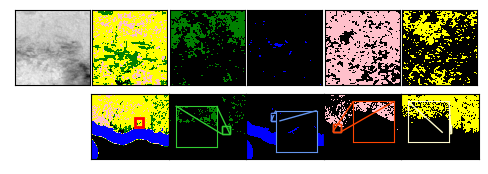

In [142]:
import os
import hydra
import glob
import sys
from omegaconf import DictConfig, OmegaConf
import omegaconf
import json

cfg_crop = omegaconf.OmegaConf.load("./configs/config_crop.yaml")
cfg_forest = omegaconf.OmegaConf.load("./configs/config_forest.yaml")
cfg_water = omegaconf.OmegaConf.load("./configs/config_water.yaml")
cfg_grass = omegaconf.OmegaConf.load("./configs/config_grass.yaml")

# cfg_loader = omegaconf.OmegaConf.load("./configs/config_loader.yaml")

testset = hydra.utils.instantiate(cfg_water.test_dataset)
test_loader = DataLoader(testset,
                         shuffle=False,
                         drop_last=False,
                         batch_size=1,
                         num_workers=16,
                         pin_memory=True,
                         sampler=None)




tester = test_all(cfg_crop, cfg_forest, cfg_water,cfg_grass, test_loader)
# tester = tester(cfg_global, cfg_ga)
tester.predict()